In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

In [3]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [4]:
out_files = []
update_list = []

## Helper functions

In [5]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [6]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [7]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [8]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [9]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [10]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [11]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [12]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [13]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [14]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs[from_level] = obs[from_level].astype(str)
        obs = obs.merge(prop_df, on = from_level, how = 'left')
        obs[from_level] = obs[from_level].astype('category')
        obs[to_level] = obs[to_level].astype('category')
        
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs

    return adata

In [15]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Cluster selection functions

In [16]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

def select_clusters_below_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] < cutoff].tolist()

    return select_cl

In [17]:
def extract_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )
    print(sel_cl)
    sel_idx = adata.obs[clusters].isin(sel_cl)
    n_extracted = sum(sel_idx)
    
    sel_adata = adata[sel_idx]
    
    return sel_adata, n_extracted

In [18]:
def remove_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )
    print(sel_cl)
    remove_idx = adata.obs[clusters].isin(sel_cl)
    n_removed = sum(remove_idx)
    keep_idx = [not x for x in remove_idx]

    adata = adata[keep_idx]
    
    return adata, n_removed

## Processing function

In [19]:
def process_adata(adata, resolution = 2):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 50,
        n_pcs = 30
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 2
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

## Markers for dotplots

In [20]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'IL7R', # T cells
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [21]:
class_markers = [
    'CD44'
]

## Read cell type hierarchy

In [22]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [23]:
search_id = 'germanium-einsteinium-indium'

Retrieve files stored in our HISE project store

In [24]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [25]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [26]:
search_df['AIFI_L3'].tolist()

['BaEoMaP cell', 'CLP cell', 'CMP cell', 'Erythrocyte', 'Platelet']

## Filter BaEoMaP cell

### Suggested updates
- Remove CD3D+ cluster as T cell doublet
- Remove MS4A1+ cluster as B cell doublet

In [27]:
cell_type = 'BaEoMaP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [28]:
type_uuid

'84b4de9b-3bad-4a0e-b345-ee95b45f1e23'

In [29]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
total_cells = adata.shape[0]

downloading fileID: 84b4de9b-3bad-4a0e-b345-ee95b45f1e23
Files have been successfully downloaded!


### Clustering

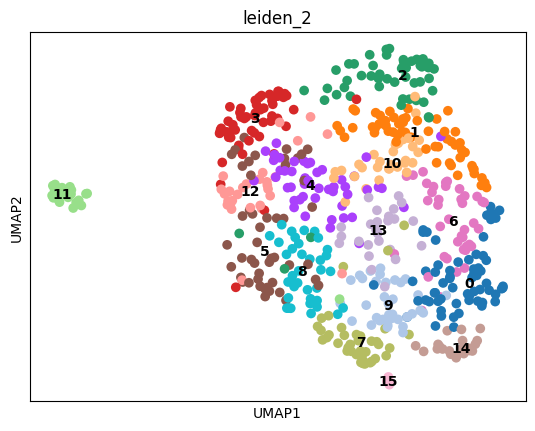

In [30]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

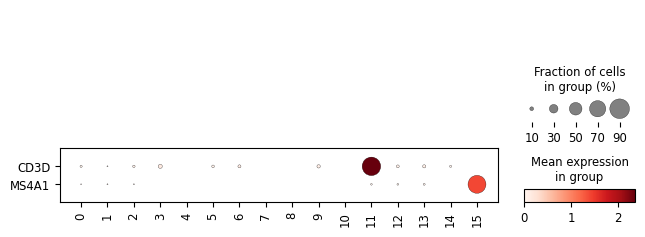

In [31]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD3D','MS4A1'], swap_axes = True)

### CD3D Selection

Filtering

In [32]:
adata, n_removed = remove_cl(
    adata, 'CD3D', 'above', 0.6, 'leiden_2'
)
n_removed

['11']


30

Reason

In [33]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['T cell doublet']
    }
)
update_list.append(update_df)

### MS4A1 Selection

Filtering

In [34]:
adata, n_removed = remove_cl(
    adata, 'MS4A1', 'above', 0.6, 'leiden_2'
)
n_removed

['15']


5

Reason

In [35]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['B cell doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [36]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


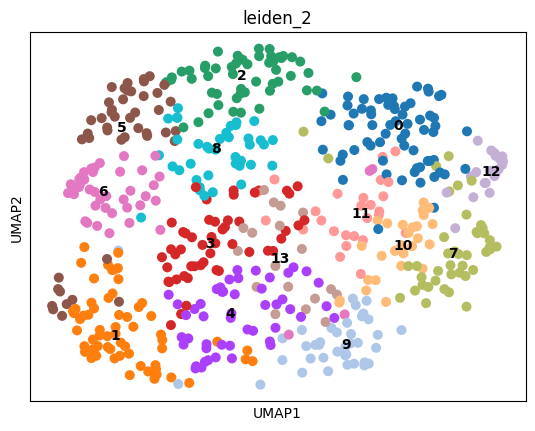

In [37]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [38]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Filter CLP cell

### Suggested updates
- Remove IRF8+ cluster (16) as DC doublet

In [39]:
cell_type = 'CLP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [40]:
type_uuid

'bf5350bd-0aff-468e-9736-c3baea442fd8'

In [41]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
total_cells = adata.shape[0]

downloading fileID: bf5350bd-0aff-468e-9736-c3baea442fd8
Files have been successfully downloaded!


### Clustering

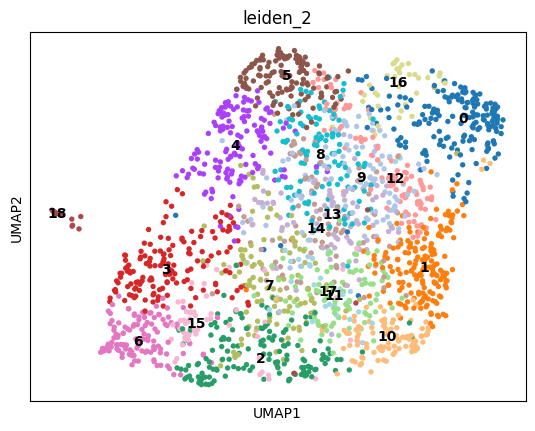

In [42]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

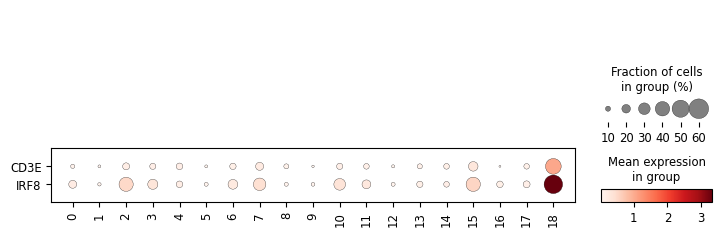

In [43]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD3E','IRF8'], swap_axes = True)

### IRF8 Selection

Filtering

In [44]:
adata, n_removed = remove_cl(
    adata, 'CD3E', 'above', 0.4, 'leiden_2'
)
n_removed

['18']


18

Reason

In [45]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['DC doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [46]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


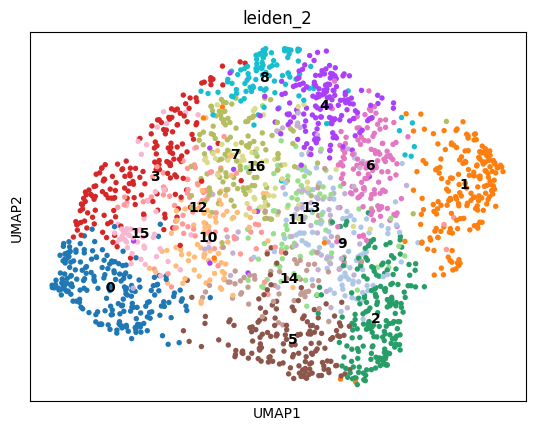

In [47]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [48]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Pass-through CMP cell

### Suggested updates
No changes suggested

In [49]:
cell_type = 'CMP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [50]:
type_uuid

'9b23db05-6e1f-45df-b01e-0bbaa5a0280b'

In [51]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
adata = propagate_hierarchy(adata, hierarchy_df)

downloading fileID: 9b23db05-6e1f-45df-b01e-0bbaa5a0280b
Files have been successfully downloaded!


In [52]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review Erythrocyte

### Suggested updates
- Remove PPBP+ cluster (18) as Platelet doublet

In [53]:
cell_type = 'Erythrocyte'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [54]:
type_uuid

'69447a1b-0f14-4554-8909-f8992b88d785'

In [55]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
total_cells = adata.shape[0]

downloading fileID: 69447a1b-0f14-4554-8909-f8992b88d785
Files have been successfully downloaded!


### Clustering

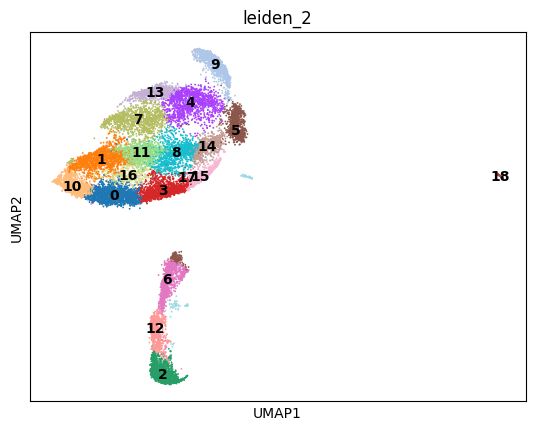

In [56]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

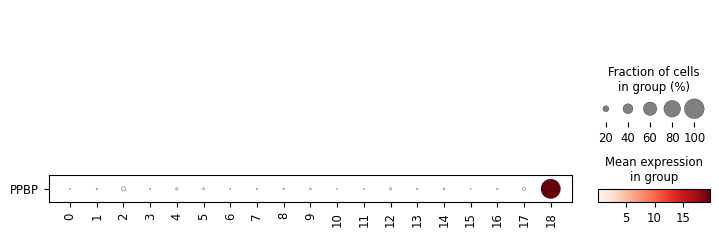

In [57]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['PPBP'], swap_axes = True)

### PPBP Selection

Filtering

In [58]:
adata, n_removed = remove_cl(
    adata, 'PPBP', 'above', 0.6, 'leiden_2'
)
n_removed

['18']


166

Reason

In [59]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Platelet doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [60]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


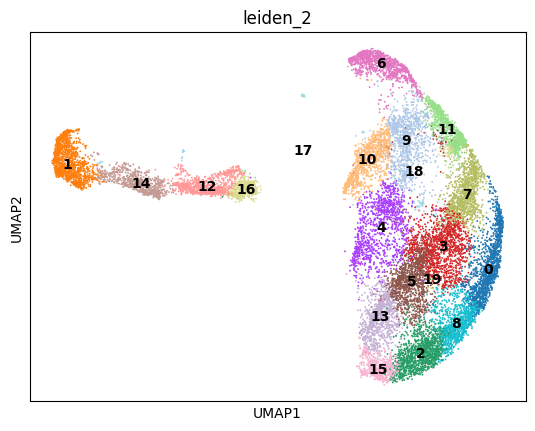

In [61]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [62]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review Platelet

### Suggested updates
- Remove HBB+ cluster (12) as Erythrocyte doublet
- Remove FCN1+ cluster (22) as Myeloid doublet

In [63]:
cell_type = 'Platelet'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [64]:
type_uuid

'947f1743-d4a7-410a-b226-8f873663445a'

In [65]:
adata = read_adata_uuid(type_uuid)
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']
total_cells = adata.shape[0]

downloading fileID: 947f1743-d4a7-410a-b226-8f873663445a
Files have been successfully downloaded!


### Clustering

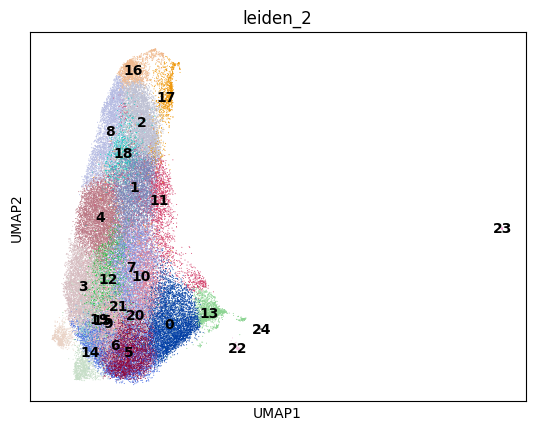

In [66]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

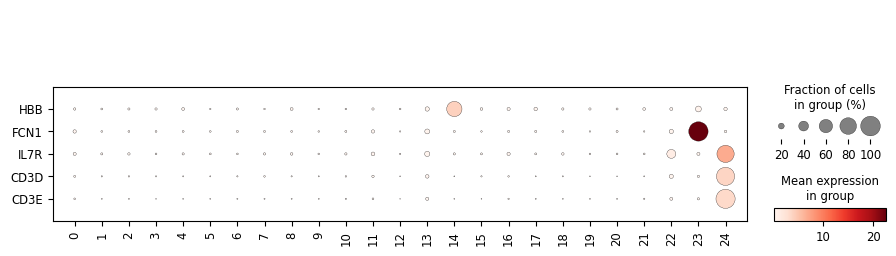

In [67]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['HBB', 'FCN1','IL7R','CD3D', 'CD3E'], swap_axes = True)

### HBB Selection

Filtering

In [68]:
adata, n_removed = remove_cl(
    adata, 'HBB', 'above', 0.6, 'leiden_2'
)
n_removed

['14']


1665

Reason

In [69]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Erythrocyte doublet']
    }
)
update_list.append(update_df)

### FCN1 Selection

Filtering

In [70]:
adata, n_removed = remove_cl(
    adata, 'FCN1', 'above', 0.6, 'leiden_2'
)
n_removed

['23']


105

Reason

In [71]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Myeloid doublet']
    }
)
update_list.append(update_df)

### CD3D Selection

Filtering

In [72]:
adata, n_removed = remove_cl(
    adata, 'CD3D', 'above', 0.4, 'leiden_2'
)
n_removed

['24']


31

Reason

In [73]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['T cell doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [74]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


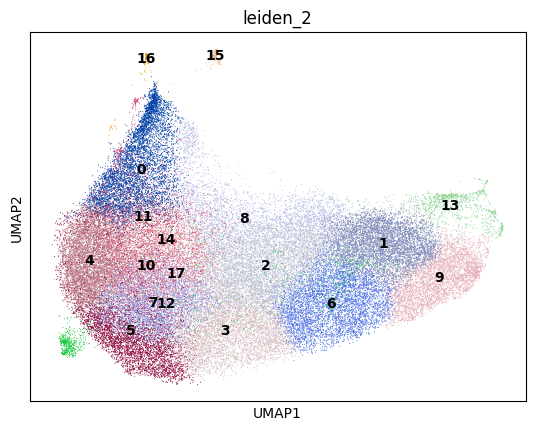

In [75]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

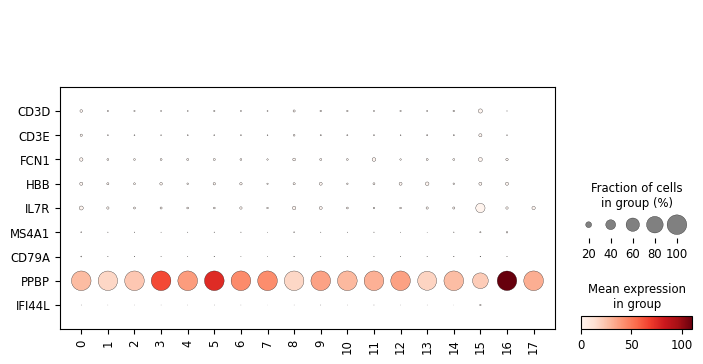

In [76]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

### Save filtered cells

In [77]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Assemble update reasoning

In [78]:
update_df = pd.concat(update_list)

In [79]:
update_df

,AIFI_L3,update_type,n_total,n_updated,change_to
0,BaEoMaP cell,remove,614,30,T cell doublet
0,BaEoMaP cell,remove,614,5,B cell doublet
0,CLP cell,remove,2003,18,DC doublet
0,Erythrocyte,remove,17619,166,Platelet doublet
0,Platelet,remove,58944,1665,Erythrocyte doublet
0,Platelet,remove,58944,105,Myeloid doublet
0,Platelet,remove,58944,31,T cell doublet


In [80]:
out_update = 'output/diha_filtered_celltypist_other_types_reasons_{d}.csv'.format(d = date.today())
update_df.to_csv(out_update)
out_files.append(out_update)

## Upload Cell Type data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [81]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA CellTypist L3 Other Types Filter {d}'.format(d = date.today())

In [82]:
search_id = element_id()
search_id

'thorium-zirconium-nobelium'

In [83]:
in_files = search_df['id'].tolist()
in_files = in_files + [hierarchy_uuid]

In [84]:
out_files

['output/diha_filtered_celltypist_L3_BaEoMaP_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_CLP_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_CMP_cell_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_Erythrocyte_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_L3_Platelet_2024-04-24.h5ad',
 'output/diha_filtered_celltypist_other_types_reasons_2024-04-24.csv']

In [85]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    destination = search_id
)

Cannot determine the current notebook.
1) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/02-reference_labeling/12g-Python_filter_L3_other_data.ipynb
2) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/02-reference_labeling/13g-Python_review_filtered_L3_other_data.ipynb
3) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/02-reference_labeling/12e-Python_filter_L3_myeloid_data.ipynb
Please select (1-3) 


 1


you are trying to upload file_ids... ['output/diha_filtered_celltypist_L3_BaEoMaP_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_CLP_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_CMP_cell_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_Erythrocyte_2024-04-24.h5ad', 'output/diha_filtered_celltypist_L3_Platelet_2024-04-24.h5ad', 'output/diha_filtered_celltypist_other_types_reasons_2024-04-24.csv']. Do you truly want to proceed?


(y/n) y


{'trace_id': '5df88d8e-fa42-43c8-bc1f-65f3ea9a7044',
 'files': ['output/diha_filtered_celltypist_L3_BaEoMaP_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_CLP_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_CMP_cell_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_Erythrocyte_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_L3_Platelet_2024-04-24.h5ad',
  'output/diha_filtered_celltypist_other_types_reasons_2024-04-24.csv']}

In [86]:
import session_info
session_info.show()